# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here

    # Calculate the number of tokens
    num_tokens = len(tokens)
    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))
    # Calculate the lexical diversity
    lexical_diversity = num_unique_tokens / num_tokens
    # Calculate the number of characters
    num_characters = sum([len(t) for t in tokens])

    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print("The five most common tokens:")
        token_counts = Counter(tokens) # 5 is the default
        for token, count in token_counts.most_common(5):
            print(f"{token}: {count}")
        print("\n")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [t for t in tokens if t not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return text.lower().strip().split() 

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/sophie/ads509-tm-group-comp/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here
lyrics_data = defaultdict(dict)

for item in os.listdir(data_location + lyrics_folder):
    if os.path.isdir(data_location + lyrics_folder + item):
        for lyrics_page in os.listdir(data_location + lyrics_folder + item):
            artist = lyrics_page.split("_")[0]
            # Get the song name from the first line of the txt file
            with open(data_location + lyrics_folder + item + "/" + lyrics_page) as file:
                song = file.readline().strip()  # Read the first line and remove any extra spaces/newlines
                lyrics = file.read()  # Read the rest of the file for the lyrics
            lyrics_data[item][song] = lyrics

# Create a DataFrame with the lyrics data
lyrics_data = pd.DataFrame.from_dict(lyrics_data, orient='index').T
lyrics_data.index.name = 'song'
lyrics_data.columns.name = 'artist'
# Transpose the DataFrame
lyrics_data = lyrics_data.stack().reset_index()
lyrics_data.columns = ['song', 'artist', 'lyrics']

lyrics_data

,song,artist,lyrics
0,"""Include Me Out""",robyn,\n\n\nIt is really very simple\nJust a single ...
1,"""Electric""",robyn,\n\n\nElectric...\n\nIt's electric\nIt's a nat...
2,"""Beach 2K20""",robyn,\n\n\n(So you wanna go out?\nHow you gonna get...
3,"""Love Kills""",robyn,\n\n\nIf you're looking for love\nGet a heart ...
4,"""Time Machine""",robyn,"\n\n\nHey, what did I do?\nCan't believe the f..."
...,...,...,...
401,"""Take It From The Boys""",cher,\n\n\nSo scared I never been\nToo hard to keep...
402,"""Dream Baby""",cher,\n\n\nI found the boy for me\nHe's my dream ba...
403,"""Please Don't Tell Me""",cher,\n\n\nYa shook the override \nWhy'd I get this...
404,"""I Hope You Find It""",cher,"\n\n\nThese clouds aren't going nowhere, darli..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
6220,cher,CEO of A.O.V. Adults Only Video 📼 🥀 https://t....,"[ceo, aov, adults, video, 📼, 🥀, httpstcoc8mequ..."
3366266,cher,me fui a ser feliz no se cuando vuelvo 😄😄😄😄😉😉😉😉,"[fui, ser, feliz, se, cuando, vuelvo, 😄😄😄😄😉😉😉😉]"
183519,cher,✨ I make music ✨ she/her ✨,"[✨, make, music, ✨, sheher, ✨]"
100615,cher,🇬🇧 in 🇺🇲 News Writer @thedigitalfix 🟡Features ...,"[🇬🇧, 🇺🇲, news, writer, thedigitalfix, 🟡feature..."
990350,cher,IT Systems Architect for Antifa. She/Her. SciF...,"[systems, architect, antifa, sheher, scifi, co..."
1311546,cher,student nurse 💉💊 love music🎧 adore Allah 🕋 eng...,"[student, nurse, 💉💊, love, music🎧, adore, alla..."
792583,cher,23 he/him🏳️‍🌈 Dms open 📖 Gay and sadly single....,"[23, hehim🏳️‍🌈, dms, open, 📖, gay, sadly, sing..."
744542,cher,34🎂♍ NorCal Raised 🛫 SoCal Living. Ⓛⓘⓥⓘⓝⓖ Ⓜⓨ Ⓑ...,"[34🎂♍, norcal, raised, 🛫, socal, living, ⓛⓘⓥⓘⓝ..."
3004097,cher,22. I do theatre and shit. Slytherin with a hi...,"[22, theatre, shit, slytherin, hint, hufflepuf..."
1438595,cher,looking to new friends 👬,"[looking, new, friends, 👬]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement to the tokenization would be to fix any spelling mistakes in the twitter data to make the tokenization more consistent for analysis. User-generated data has a lot of spelling mistakes, this could be beneficial to fix.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
# your code here
# Flatten the list of tokens using this function for descriptive stats
lyrics_tokens = [token for tokens in lyrics_data['tokens'] for token in tokens]

# Artist cher stats
cher_lyrics_data = lyrics_data[lyrics_data['artist'] == 'cher']
cher_tokens = [token for tokens in cher_lyrics_data['tokens'] for token in tokens]
print(f"Cher Lyrics Stats: {descriptive_stats(cher_tokens)}\n")

# Artist robyn stats
robyn_lyrics_data = lyrics_data[lyrics_data['artist'] == 'robyn']
robyn_tokens = [token for tokens in robyn_lyrics_data['tokens'] for token in tokens]
print(f"Robyn Lyrics Stats: {descriptive_stats(robyn_tokens)}\n")

There are 34922 tokens in the data.
There are 3682 unique tokens in the data.
There are 167670 characters in the data.
The lexical diversity is 0.105 in the data.
The five most common tokens:
love: 923
im: 509
know: 475
dont: 428
youre: 332


Cher Lyrics Stats: [34922, 3682, 0.10543496936028865, 167670]

There are 13019 tokens in the data.
There are 2139 unique tokens in the data.
There are 62663 characters in the data.
The lexical diversity is 0.164 in the data.
The five most common tokens:
im: 255
dont: 252
love: 238
know: 237
got: 230


Robyn Lyrics Stats: [13019, 2139, 0.1642983332053153, 62663]



Q: what observations do you make about these data? 

A: Some observations I made from the data is that the top 5 words from Robyn and Cher lyrics are identical.  Robyn has a slightly larger lexical diverity of 0.164, while Cher has a lexical diversity of 0.105.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [19]:
# Set threshold, get top n tokens
n = 10

# Function to calculate concentration ratio
def calculate_concentration_ratio(df, corpus_name):
    """
    Calculate the concentration ratio of the top n tokens in a DataFrame.
    """
    # Flatten the list of tokens
    tokens = [token for tokens in df['tokens'] for token in tokens]
    
    # Count the number of tokens
    token_counts = Counter(tokens)
    
    # Get the total number of tokens
    total_tokens = sum(token_counts.values())
    
    # Get the top n tokens
    top_n_tokens = token_counts.most_common(n)
    
    # Calculate concentration ratio
    concentration_ratio = {token: count / total_tokens for token, count in top_n_tokens}
    
    return concentration_ratio

# Lyrics data 
print("Concentration Ratios - Lyrics Data:")
concentration_ratios = {}
for artist in lyrics_data['artist'].unique():
    artist_data = lyrics_data[lyrics_data['artist'] == artist]
    concentration_ratios[artist] = calculate_concentration_ratio(artist_data, artist)

for artist, concentration_ratio in concentration_ratios.items():
    print(f"{artist}:")
    for token, ratio in concentration_ratio.items():
        print(f"  {token}: {ratio:.4f}")
    print()

# Twitter data 
print("Concentration Ratios -Twitter Data:")
twitter_concentration_ratios = {}
for artist in twitter_data['artist'].unique():
    artist_data = twitter_data[twitter_data['artist'] == artist]
    twitter_concentration_ratios[artist] = calculate_concentration_ratio(artist_data, artist)

for artist, concentration_ratio in twitter_concentration_ratios.items():
    print(f"{artist}:")
    for token, ratio in concentration_ratio.items():
        print(f"  {token}: {ratio:.4f}")
    print()


Concentration Ratios (Lyrics Data):
robyn:
  im: 0.0196
  dont: 0.0194
  love: 0.0183
  know: 0.0182
  got: 0.0177
  baby: 0.0162
  like: 0.0156
  never: 0.0110
  youre: 0.0109
  get: 0.0100

cher:
  love: 0.0264
  im: 0.0146
  know: 0.0136
  dont: 0.0123
  youre: 0.0095
  baby: 0.0090
  time: 0.0090
  see: 0.0088
  oh: 0.0084
  one: 0.0079

Concentration Ratios (Twitter Data):
cher:
  nan: 0.1129
  love: 0.0121
  im: 0.0079
  life: 0.0069
  music: 0.0049
  de: 0.0041
  follow: 0.0035
  lover: 0.0034
  like: 0.0033
  mom: 0.0030

robyn:
  nan: 0.1012
  music: 0.0089
  love: 0.0070
  im: 0.0054
  och: 0.0048
  life: 0.0044
  de: 0.0038
  follow: 0.0033
  like: 0.0030
  en: 0.0029



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens in the lyrics data is almost identical between both artists, with some keyword differences like "never" in robyn and "oh" and "one" in cher lyrics. In the twitter data, the top tokens are similar in both artists with some differences but overall consistent with one another. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [20]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

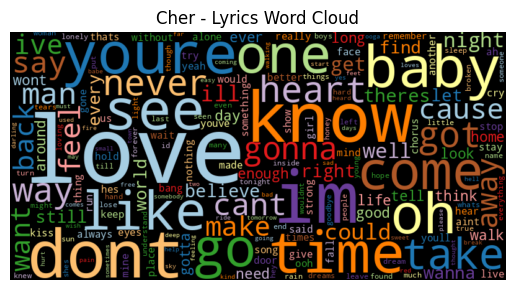

In [25]:
# create df of just artist cher from lyrics_data 
cher_lyrics_data = lyrics_data[lyrics_data['artist'] == 'cher']

# Count token frequency
cher_freq = count_words(cher_lyrics_data)

# Create wordcloud 
wordcloud(cher_freq['freq'], title="Cher - Lyrics Word Cloud")
plt.show()

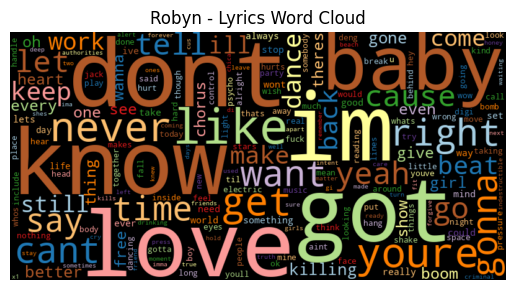

In [26]:
# create df of just artist cher from lyrics_data 
robyn_lyrics_data = lyrics_data[lyrics_data['artist'] == 'robyn']

# Count token frequency
robyn_freq = count_words(robyn_lyrics_data)

# Create wordcloud 
wordcloud(robyn_freq['freq'], title="Robyn - Lyrics Word Cloud")
plt.show()

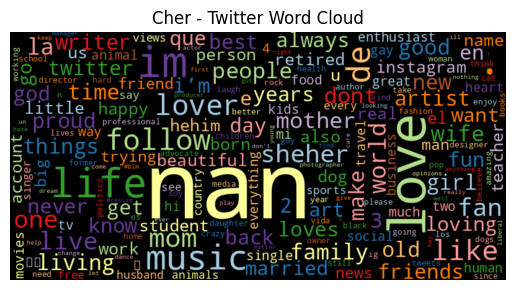

In [27]:
# Twitter data 

# create df of just artist cher from twitter_data
cher_twitter_data = twitter_data[twitter_data['artist'] == 'cher']

# Count token frequency
cher_twitter_freq = count_words(cher_twitter_data)

# Create wordcloud
wordcloud(cher_twitter_freq['freq'], title="Cher - Twitter Word Cloud")
plt.show()

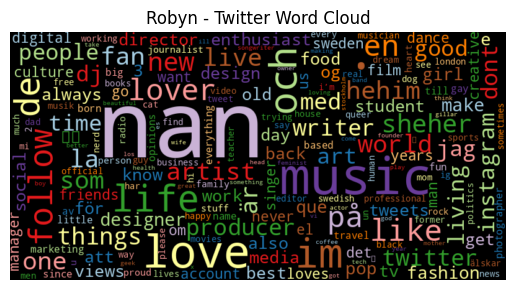

In [28]:
# create df of just artist robyn from twitter_data
robyn_twitter_data = twitter_data[twitter_data['artist'] == 'robyn']

# Count token frequency
robyn_twitter_freq = count_words(robyn_twitter_data)

# Create wordcloud
wordcloud(robyn_twitter_freq['freq'], title="Robyn - Twitter Word Cloud")
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The wordclouds for both Cher and Robyn show considerable overlap in terms of lyrical themes with frequent words like "love," and "baby," and Twitter discussions, with frequent words like “love,” “life,” “music,” and “world.” This suggests both artists explore universal, emotionally resonant topics in their songs and attract similar discussions in the Twitter environment online. 